# Data Mining & Machine Learning - Classification Part 3.2

### Case 1: Classification of Legendary Pokémon with Supervised Learning

83109 Samuel Didovic<br>
86368 Isabel Lober<br>
85915 Pascal Seitz<br>

Lecturer: Prof. Dr. Adrian Moriariu

In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc, roc_auc_score, f1_score, precision_recall_curve

from sklearn.tree import DecisionTreeClassifier

In [3]:
df = pd.read_csv("pokemon_cleaned.csv")
df["type2"].fillna("None", inplace = True)
df["percentage_male"].fillna("None", inplace = True)

In [4]:
df_train = df.drop(columns = ["name", "abilities", "classification"], axis = 1)
df_train = pd.get_dummies(df_train, columns = ["type1", "type2", "percentage_male"], dtype = int, drop_first = False)

The `train_test_split` function is a utility provided by the `sklearn.model_selection` module. It is used to split a dataset into training and testing subsets.

- **test_size**: This parameter specifies the proportion of the dataset to include in the test split. We set it to `0.2`, meaning 20 % of the data will be used for testing, and the remaining 80 % will be used for training.

- **random_state**: This parameter controls the shuffling applied to the data before the split. Setting it to a specific integer value (e.g., `42`) ensures that the split will be reproducible. Every time the code is run with the same `random_state`, the result will be the same.

- **stratify**: This parameter ensures that the training and test sets have the same proportion of samples for each class as the original dataset. It is particularly useful for imbalanced datasets. By passing the target variable `y`, we ensure that the class distribution is maintained in both the training and test sets.

In [5]:
# Define features and target variable
X = df_train.drop(columns = ["is_legendary"], axis = 1).values
y = df_train["is_legendary"].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 101, stratify = y)

print(f"Training set size: {X_train.shape[0]}")
print(f"Test set size: {X_test.shape[0]}")

Training set size: 640
Test set size: 161


## 2. DecisionTreeClassifier

### 2.1 DecisionTree - a first approach

**Scaling**

When using certain machine learning algorithms, such as k-nearest neighbors (kNN), feature scaling is crucial because these algorithms are sensitive to the magnitudes of the features. Scaling ensures that all features contribute equally to the result and that the distance metrics are properly computed.

However, DecisionTree is a tree-based learning method.

1. **Tree-Based Algorithms**: DecisionTree, as well as ensemble learning methods (e.g., Random Forest, Gradient Boosting), is not affected by the scale of the input features. These algorithms split the data based on feature values without considering their magnitudes. Each split is made by comparing feature values to thresholds, and the specific values are not influenced by the range or distribution of the data.

2. **Invariance to Feature Scale**: DescisionTree can handle different scales of features because the algorithm only looks at the ordering of the feature values rather than their absolute values. This means that whether a feature ranges from 1 to 1000 or from 0.001 to 0.1, the splits will be based on the relative ordering of the data points.

3. **No Assumption of Normality**: DecisionTree does not make assumptions such as normal distribution. Hence, there is no need to normalize or standardize the data to fit a particular distribution.

Therefore, when using DecisionTree for classification or regression tasks, scaling the features is not necessary. This allows to focus on other aspects of model tuning and evaluation.

In [6]:
# Initialize the DecisionTree model
tree = DecisionTreeClassifier()
tree.fit(X_train, y_train)

DecisionTreeClassifier()

In [7]:
# Actual prediction
y_train_pred = tree.predict(X_train)
y_test_pred = tree.predict(X_test)

**Evaluation Metrics**

- **Precision**: The ratio of correctly predicted positive observations to the total predicted positives. High precision indicates a low false positive rate.
- **Recall**: The ratio of correctly predicted positive observations to all observations in the actual class. High recall indicates a low false negative rate.
- **F1-Score**: The weighted average of precision and recall. It is useful when the class distribution is imbalanced.
- **Cross-Validation F1-Score**: The average F1-Score across different folds of the dataset.
- **AUC-ROC**: A measure of the model's ability to distinguish between classes. Higher AUC indicates better performance.

Training accuracy: 1.0000
Testing accuracy: 1.0000
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00       147
           1       1.00      1.00      1.00        14

    accuracy                           1.00       161
   macro avg       1.00      1.00      1.00       161
weighted avg       1.00      1.00      1.00       161

Cross-Validation F1-Score: [1.         0.90909091 0.90909091 1.         1.        ]
Average Cross-Validation F1-Score: 0.9636
AUC-ROC: 1.0000


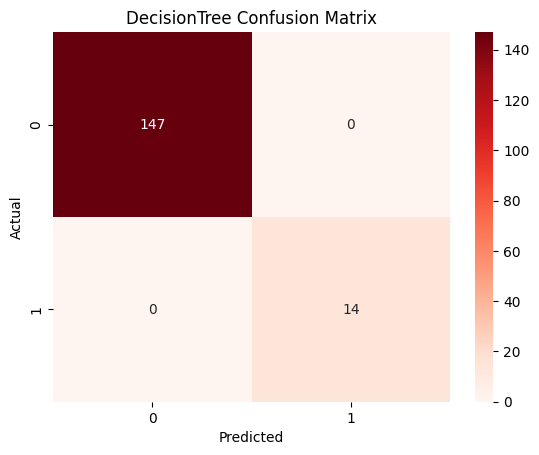

In [8]:
# Evaluation of the model
train_score = accuracy_score(y_train, y_train_pred)
test_score = accuracy_score(y_test, y_test_pred)
classification_rep = classification_report(y_test, y_test_pred)

# Cross-Validation scores
skf = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 101)
cv_scores = cross_val_score(tree, X_train, y_train, cv = skf, scoring = "f1")

# AUC_ROC
y_test_prob = tree.predict_proba(X_test)[:, 1]
auc_roc = roc_auc_score(y_test, y_test_prob)

# Print the metrics
print(f"Training accuracy: {train_score:.4f}")
print(f"Testing accuracy: {test_score:.4f}")
print("Classification Report:\n", classification_rep)
print(f"Cross-Validation F1-Score: {(cv_scores)}")
print(f"Average Cross-Validation F1-Score: {np.mean(cv_scores):.4f}")
print(f"AUC-ROC: {auc_roc:.4f}")

# Confusion Matrix
cm_tree = confusion_matrix(y_test, y_test_pred)
sns.heatmap(cm_tree, annot = True, fmt = "d", cmap = "Reds")
plt.title("DecisionTree Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

**Precision-Recall Curve**

The Precision-Recall curve is a graphical representation of the trade-off between precision and recall for different threshold values of a classification model. It is especially useful when dealing with imbalanced datasets.

- **Precision**: The ratio of correctly predicted positive observations to the total predicted positives.
- **Recall**: The ratio of correctly predicted positive observations to all observations in the actual class.

The curve helps in understanding the balance between precision and recall. A high area under the curve represents both high recall and high precision, indicating a model with good performance.

**ROC Curve and AUC-ROC**

The ROC (Receiver Operating Characteristic) curve is a graphical representation of the diagnostic ability of a binary classifier system as its discrimination threshold is varied. It plots the True Positive Rate (Recall) against the False Positive Rate.

- **True Positive Rate (Recall)**: The ratio of correctly predicted positive observations to all actual positives.
- **False Positive Rate**: The ratio of incorrectly predicted positive observations to all actual negatives.

The AUC-ROC (Area Under the ROC Curve) provides a single measure of overall model performance. A higher AUC value indicates a better-performing model.

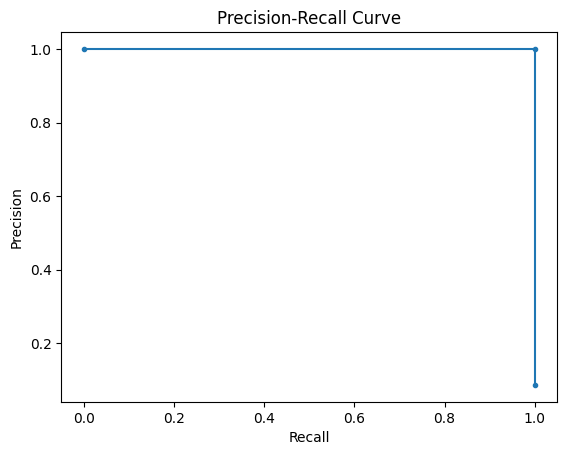

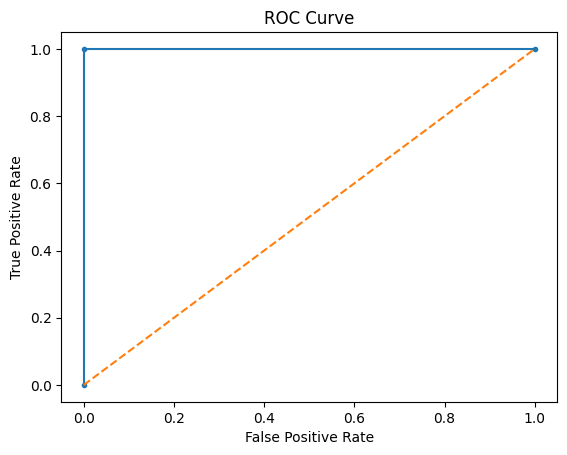

In [9]:
# Precision-Recall Curve
y_scores = tree.predict_proba(X_test)[:, 1]
precision, recall, _ = precision_recall_curve(y_test, y_scores)

plt.plot(recall, precision, marker='.')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.show()

# ROC-Curve und AUC-value
fpr, tpr, _ = roc_curve(y_test, y_scores)
roc_auc = roc_auc_score(y_test, y_scores)

plt.plot(fpr, tpr, marker='.')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'ROC Curve')
plt.show()

### 2.2 Improved RandomForest by addressing Class Imbalance and Parameters

In our initial model, we trained a DecistionTree model without considering parameters and addressing class imbalance. This was intended to demonstrate the importance of these steps:
1. **Prone to overfitting**: Decision Trees are prone to overfitting, especially when they are deep and complex. Further, Decision Trees are sensitive to the parameters chosen.
2. **Class Imbalance**: Ignoring class imbalance can lead to biased predictions, favoring the majority class.

In [10]:
# Initialize the DecisionTree model with parameters (other than default) and address class imbalance with "balanced"
tree = DecisionTreeClassifier(criterion = "entropy", max_depth = 2, min_samples_leaf = 10, min_samples_split = 5, class_weight = "balanced", random_state = 101)
tree.fit(X_train, y_train)

DecisionTreeClassifier(class_weight='balanced', criterion='entropy',
                       max_depth=2, min_samples_leaf=10, min_samples_split=5,
                       random_state=101)

In [11]:
# Actual prediction
y_train_pred = tree.predict(X_train)
y_test_pred = tree.predict(X_test)

**Evaluation Metrics**

- **Precision**: The ratio of correctly predicted positive observations to the total predicted positives. High precision indicates a low false positive rate.
- **Recall**: The ratio of correctly predicted positive observations to all observations in the actual class. High recall indicates a low false negative rate.
- **F1-Score**: The weighted average of precision and recall. It is useful when the class distribution is imbalanced.
- **Cross-Validation F1-Score**: The average F1-Score across different folds of the dataset.
- **AUC-ROC**: A measure of the model's ability to distinguish between classes. Higher AUC indicates better performance.

Training accuracy: 0.9219
Testing accuracy: 0.9503
Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.95      0.97       147
           1       0.64      1.00      0.78        14

    accuracy                           0.95       161
   macro avg       0.82      0.97      0.87       161
weighted avg       0.97      0.95      0.96       161

Cross-Validation F1-Score: [0.81481481 0.91666667 0.52631579 0.88       0.66666667]
Average Cross-Validation F1-Score: 0.7609
AUC-ROC: 0.9966


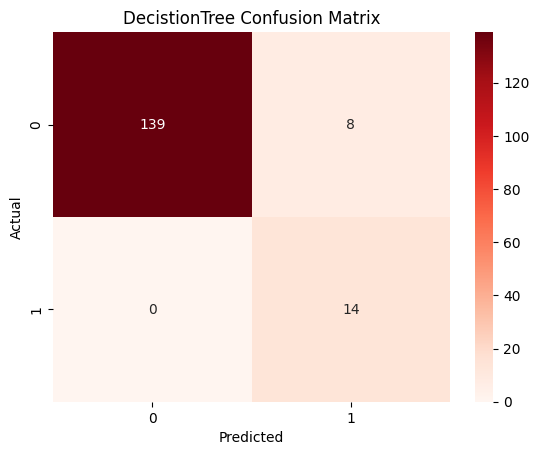

In [12]:
# Evaluation of the model
train_score = accuracy_score(y_train, y_train_pred)
test_score = accuracy_score(y_test, y_test_pred)
classification_rep = classification_report(y_test, y_test_pred)

# Cross-Validation scores
skf = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 101)
cv_scores = cross_val_score(tree, X_train, y_train, cv = skf, scoring = "f1")

# AUC_ROC
y_test_prob = tree.predict_proba(X_test)[:, 1]
auc_roc = roc_auc_score(y_test, y_test_prob)

# Print the metrics
print(f"Training accuracy: {train_score:.4f}")
print(f"Testing accuracy: {test_score:.4f}")
print("Classification Report:\n", classification_rep)
print(f"Cross-Validation F1-Score: {(cv_scores)}")
print(f"Average Cross-Validation F1-Score: {np.mean(cv_scores):.4f}")
print(f"AUC-ROC: {auc_roc:.4f}")

# Confusion Matrix
cm_tree = confusion_matrix(y_test, y_test_pred)
sns.heatmap(cm_tree, annot = True, fmt = "d", cmap = "Reds")
plt.title("DecistionTree Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

**Precision-Recall Curve**

The Precision-Recall curve is a graphical representation of the trade-off between precision and recall for different threshold values of a classification model. It is especially useful when dealing with imbalanced datasets.

- **Precision**: The ratio of correctly predicted positive observations to the total predicted positives.
- **Recall**: The ratio of correctly predicted positive observations to all observations in the actual class.

The curve helps in understanding the balance between precision and recall. A high area under the curve represents both high recall and high precision, indicating a model with good performance.

**ROC Curve and AUC-ROC**

The ROC (Receiver Operating Characteristic) curve is a graphical representation of the diagnostic ability of a binary classifier system as its discrimination threshold is varied. It plots the True Positive Rate (Recall) against the False Positive Rate.

- **True Positive Rate (Recall)**: The ratio of correctly predicted positive observations to all actual positives.
- **False Positive Rate**: The ratio of incorrectly predicted positive observations to all actual negatives.

The AUC-ROC (Area Under the ROC Curve) provides a single measure of overall model performance. A higher AUC value indicates a better-performing model.

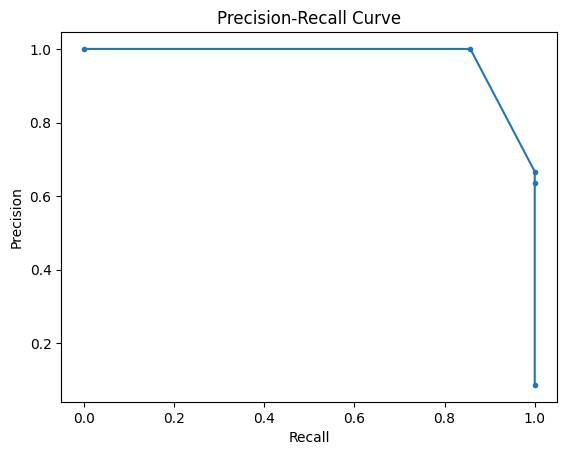

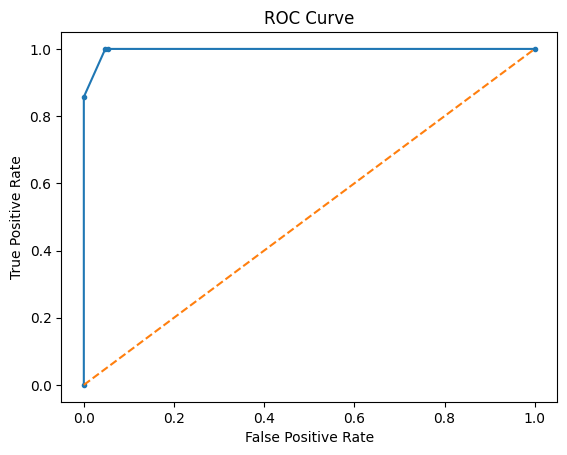

In [13]:
# Precision-Recall Curve
y_scores = tree.predict_proba(X_test)[:, 1]
precision, recall, _ = precision_recall_curve(y_test, y_scores)

plt.plot(recall, precision, marker='.')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.show()

# ROC-Curve und AUC-value
fpr, tpr, _ = roc_curve(y_test, y_scores)
roc_auc = roc_auc_score(y_test, y_scores)

plt.plot(fpr, tpr, marker='.')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'ROC Curve')
plt.show()

### 2.3 Hyperparameter Optimization using GridSearchCV

In our initial models, we saw that DecisionTree was sensitive to parameters and class imbalance. We addressed these issues and improved the model by showcasing a much more realistic state, using some parameters and handling class imbalance using the `class_weight='balanced'` parameter.

Despite improvements, our model can still be fine-tuned. Hyperparameter optimization using `GridSearchCV` helps in finding the best combination of hyperparameters for our model, leading to potentially better performance.

`GridSearchCV` performs an exhaustive search over a specified parameter grid.

1. **Parameter Grid**: Define a range of hyperparameters to search.
    - `max_depth`: Maximum depth of the tree.
    - `min_samples_split`: Weight function used in prediction ('uniform' or 'distance').
    - `min_samples_leaf`: Minimum number of samples required to be at a leaf node.
    - `criterion`: Function to measure the quality of a split ('gini' or 'entropy').
    - `class_weight`: Weights associated with classes ('balanced').

2. **Cross-Validation**: Use 5-fold cross-validation to evaluate the model.

3. **Scoring**: Use `f1` to optimize for a balance between precision and recall, especially in imbalanced datasets.

In [14]:
# Define parameters for Grid Search
param_grid = {
    "max_depth": [None, 3, 6, 9, 12],
    "min_samples_split": [2, 5, 10, 20],
    "min_samples_leaf": [1, 2, 4, 10],
    "criterion": ["gini", "entropy"],
    "class_weight": ["balanced"]
}

# Initialize the model
tree_grid = DecisionTreeClassifier(random_state = 101)

# Grid Search with Cross Validation
grid_search_tree = GridSearchCV(estimator = tree_grid,
                          param_grid = param_grid,
                          cv = 5,
                          scoring = "f1",
                          n_jobs = -1,
                          verbose = 2)

grid_search_tree.fit(X_train, y_train)

Fitting 5 folds for each of 160 candidates, totalling 800 fits


GridSearchCV(cv=5, estimator=DecisionTreeClassifier(random_state=101),
             n_jobs=-1,
             param_grid={'class_weight': ['balanced'],
                         'criterion': ['gini', 'entropy'],
                         'max_depth': [None, 3, 6, 9, 12],
                         'min_samples_leaf': [1, 2, 4, 10],
                         'min_samples_split': [2, 5, 10, 20]},
             scoring='f1', verbose=2)

In [15]:
# Get best parameters
best_params = grid_search_tree.best_params_
print(f"Best parameters: {best_params}")

best = DecisionTreeClassifier(**best_params)
best.fit(X_train, y_train)

Best parameters: {'class_weight': 'balanced', 'criterion': 'entropy', 'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 2}


DecisionTreeClassifier(class_weight='balanced', criterion='entropy',
                       min_samples_leaf=2)

In [16]:
# Actual prediction
y_train_pred = best.predict(X_train)
y_test_pred = best.predict(X_test)

**Evaluation Metrics**

- **Precision**: The ratio of correctly predicted positive observations to the total predicted positives. High precision indicates a low false positive rate.
- **Recall**: The ratio of correctly predicted positive observations to all observations in the actual class. High recall indicates a low false negative rate.
- **F1-Score**: The weighted average of precision and recall. It is useful when the class distribution is imbalanced.
- **Cross-Validation F1-Score**: The average F1-Score across different folds of the dataset.
- **AUC-ROC**: A measure of the model's ability to distinguish between classes. Higher AUC indicates better performance.

Training accuracy: 0.9969
Testing accuracy: 0.9938
Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.99      1.00       147
           1       0.93      1.00      0.97        14

    accuracy                           0.99       161
   macro avg       0.97      1.00      0.98       161
weighted avg       0.99      0.99      0.99       161

Cross-Validation F1-Score: [0.95652174 0.95652174 0.90909091 1.         0.91666667]
Average Cross-Validation F1-Score: 0.9478
AUC-ROC: 0.9964


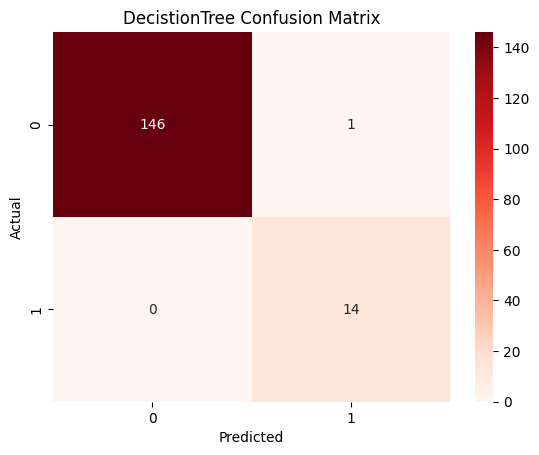

In [17]:
# Evaluation of the model
train_score = accuracy_score(y_train, y_train_pred)
test_score = accuracy_score(y_test, y_test_pred)
classification_rep = classification_report(y_test, y_test_pred)

# Cross-Validation scores
skf = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 101)
cv_scores = cross_val_score(best, X_train, y_train, cv = skf, scoring = "f1")

# AUC_ROC
y_test_prob = best.predict_proba(X_test)[:, 1]
auc_roc = roc_auc_score(y_test, y_test_prob)

# Print the metrics
print(f"Training accuracy: {train_score:.4f}")
print(f"Testing accuracy: {test_score:.4f}")
print("Classification Report:\n", classification_rep)
print(f"Cross-Validation F1-Score: {(cv_scores)}")
print(f"Average Cross-Validation F1-Score: {np.mean(cv_scores):.4f}")
print(f"AUC-ROC: {auc_roc:.4f}")

# Confusion Matrix
cm_tree = confusion_matrix(y_test, y_test_pred)
sns.heatmap(cm_tree, annot = True, fmt = "d", cmap = "Reds")
plt.title("DecistionTree Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

**Precision-Recall Curve**

The Precision-Recall curve is a graphical representation of the trade-off between precision and recall for different threshold values of a classification model. It is especially useful when dealing with imbalanced datasets.

- **Precision**: The ratio of correctly predicted positive observations to the total predicted positives.
- **Recall**: The ratio of correctly predicted positive observations to all observations in the actual class.

The curve helps in understanding the balance between precision and recall. A high area under the curve represents both high recall and high precision, indicating a model with good performance.

**ROC Curve and AUC-ROC**

The ROC (Receiver Operating Characteristic) curve is a graphical representation of the diagnostic ability of a binary classifier system as its discrimination threshold is varied. It plots the True Positive Rate (Recall) against the False Positive Rate.

- **True Positive Rate (Recall)**: The ratio of correctly predicted positive observations to all actual positives.
- **False Positive Rate**: The ratio of incorrectly predicted positive observations to all actual negatives.

The AUC-ROC (Area Under the ROC Curve) provides a single measure of overall model performance. A higher AUC value indicates a better-performing model.

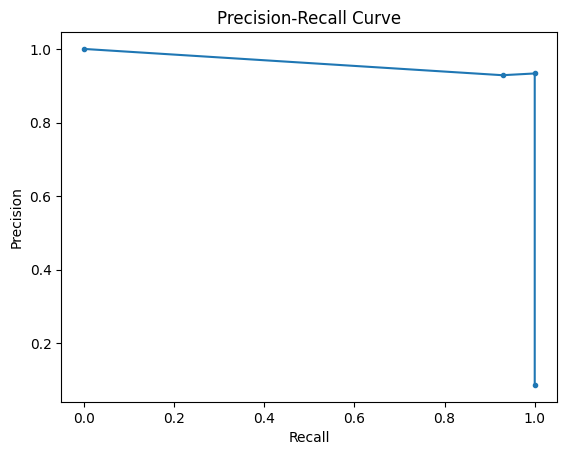

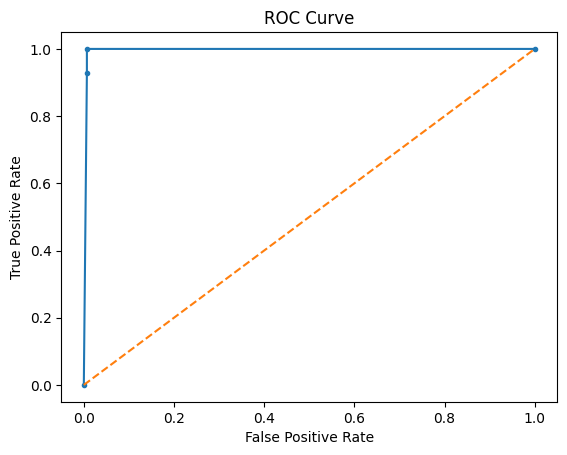

In [18]:
# Precision-Recall Curve
y_scores = best.predict_proba(X_test)[:, 1]
precision, recall, _ = precision_recall_curve(y_test, y_scores)

plt.plot(recall, precision, marker='.')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.show()

# ROC-Curve und AUC-value
fpr, tpr, _ = roc_curve(y_test, y_scores)
roc_auc = roc_auc_score(y_test, y_scores)

plt.plot(fpr, tpr, marker='.')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'ROC Curve')
plt.show()

### 2.4 Feature Importance

Now, we are about to make use of `feature_importances_`. Generating insights of important features might be of help for several reasons:

- **Understanding Model Behavoir**: This could be help getting more detailed insights of the relationships within the data.
- **Model Interpretation**: For decision tree-based models, such as `DecisionTreeClassifier`, feature importance can make the model more interpretable.
- **Improving Generalization**: By focusing on the most important features, we can reduce overfitting and improve the model's ability to generalize to unseen data in following iterations.
- **Insight for Domain Experts**: Providing feature importance to domain experts can help them understand and validate the model's decisions, ensuring that the model aligns with domain knowledge and expectations

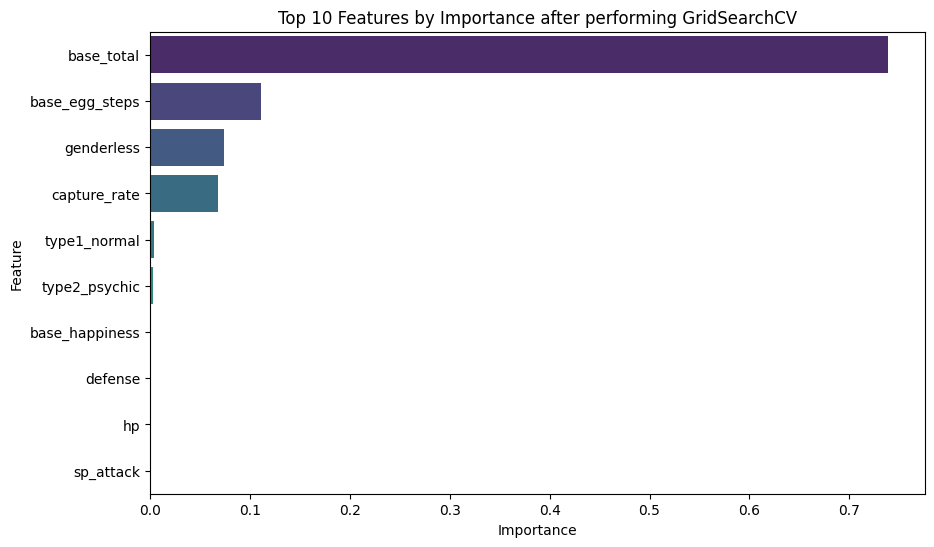

In [24]:
# Extracting feature importances
importances = best.feature_importances_

feature_names = df_train.drop(columns = ["is_legendary"], axis = 1).columns

# Store in separate df for visualization purposes
df_importances = pd.DataFrame({
    "Feature": feature_names,
    "Importance": importances
})

# Sort the df by importance
df_importances = df_importances.sort_values(by = "Importance", ascending = False)

# Get the ten most important features
top_10 = df_importances.head(10)

# Plot the features
plt.figure(figsize = (10, 6))
sns.barplot(x = "Importance", y = "Feature", data = top_10, palette = "viridis")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.title("Top 10 Features by Importance after performing GridSearchCV")

plt.show()

### 2.5 Conclusion

- The model training and evaluation showcased that the `DecisionTreeClassifier`, optimized with `GridSearchCV`, performs well in classifying legendary Pokémon.
- The detailed breakdown in the Classification Report indicate strong reliability of the model.
- An overall robustness was shown by Cross-Validation across different subsets.
- Further metrics demonstrated, that the model has a strong ability to distinguish between positive and negative classes (AUC-ROC), as well as its capability in classification tasks (ROC-Curve).
- Last but not least, `feature_importances_` revealed further insights of the Top 10 most important features contributing to the model's predictions.
- In a real-world setting, continuously monitoring the model's performance on new data and updating the model as necessary would be critical to maintaining its reliability.